<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2019 </h1>

<H3 align='center'> Tarea 3 - Ensamblados y modelos avanzados </H3>
<hr style="height:2px;border:none"/>
<H3 align='center'> Gabriel Arjona - Francisco Vásquez </H3>

**Temas**  
* Técnicas de ensamblado: *bagging*, *boosting* y *random forest*.
* Ventajas de técnicas de ensamblados
* Problemas desbalanceados
 

**Formalidades**  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y cierre competencia: 17 de Enero
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF393-II-2019]

<hr style="height:2px;border:none"/>


[1.](#primero) Ensamblados para regresión  

<a id="primero"></a>
## 1. Ensamblados para regresión
---
Las técnicas de ensamblados vistos en clases pueden ser aplicadas tanto a problemas de clasificación o regresión, teniendo la ventaja de utilizar múltiples modelos de aprendizaje para utilizar la ventaja de cada uno. En este actividad se trabajará con predecir la temperatura media de un día, dada cierta información del día anterior, como la humedad, velocidad del viento, presión atmosférica, fecha y temperatura. El modelo predictor derivado puede ser bastante útil para conocer el comportamiento del clima a lo largo del tiempo.

<img src="https://scijinks.gov/review/forecast-reliability/forecast-reliability2.jpg" title="Title text" width="70%"  />

Los datos de clima son recolectados en la ciudad Delhi de India por un período de 4 años (2013 a 2017), proporcionados en Kaggle a través del siguiente __[link](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data)__, las particiones de entrenamiento y prueba están dadas. El registro de cada dato corresponde a un día, incrementando a través de las filas por cada día.

---
    
>  Cargue los datos en un dataframe de pandas, además agregue una columna indicando el valor a predecir, la temperatura media del día siguiente. *Como el último dato/registro no tiene un valor a predecir éste se elimina*.
```python
import pandas as pd
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row
```

> Debido a la poca información que se tiene a través de los 4 parámetros medidos, extraíga más información a través de los datos de fecha. Por ejemplo, el comportamiento a través de los meses y años varía, así como la información de la temporada del año podría ayudar a la predicción. Decida si puede incluir más información a partir de la fecha que tenga sentido con el problema.
```python
...#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
...#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
... #any more information?
df.drop(["date"], axis=1, inplace=True) #delete date
```

> Cree las matrices de entrenamiento, con los mil primeros registros, y de validación, con el resto. Para evitar el orden natural en que vienen los datos entrenados, realice un *shuffle* aleatorio.
```python
y = df.pop("y_value").values
X = df.values 
X_train = X[:1000]
y_train = y[:1000]
X_val = X[1000:]
y_val = y[1000:]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0) #shuffle values on train only
```

> a) Describa el problema trabajado, la cantida de datos que se cuenta como las características a trabajar. Al ser datos temporales podría ayudar una ilustración gráfica de la secuencias trabajadas y su comportamiento ¿Es válido el uso de la información sólo del día anterior?.


> b) Entrene un solo Árbol de Regresión de múltiples niveles para resolver el problema. Defina un Árbol **no regularizado** (como el que no tiene límites en su profundidad) y otro Árbol **regularizado** (variando los hiper-parámetros que prefiera, por ejemplo, los más comunes como la profundidad, el número mínimo de datos para realizar *split* o el número mínimo de datos en cada hoja). Además comente sobre la ventaja de usar un árbol de decisión respecto a la escala de los datos ¿Porqué no es necesario escalar los datos?
```python
import numpy as np
def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )
from sklearn.tree import DecisionTreeRegressor as Tree
model_unr = Tree() #unregularized model -- default parameters
model_unr.fit(X_train,y_train)
... #define your regularized tree model
``` 

> c) Para evaluar la calidad de predicción en este problema se utilizará la métrica *Root Mean Squared Error* (RMSE), indicando un error en la escala real de la temperatura. Como los datos de validación siguen con el orden temporal, visualice esa predicción a lo largo del tiempo. Comente sobre los resultados comparando la regularización *vs* el no regularizar.
```python
y_train_hat = model.predict(X_train)
y_val_hat = model.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()
```
    
> d) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de **Bagging**, compare el Árbol **no regularizado** con el **regularizado** (*seteando los hiper-parámetros en base a lo experimentado anteriormente en b)*) ¿Qué debería suceder? ¿Se visualiza *overfitting*? Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.
```python
from sklearn.ensemble import BaggingRegressor
model = BaggingRegressor(base_estimator=Tree(...), n_estimators=..., n_jobs=-1)
```

> e) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de **AdaBoost**, compare el Árbol **no regularizado** con el **regularizado** (*seteando los hiper-parámetros en base a lo experimentado anteriormente en d)* ¿Se visualiza *overfitting*? ¿Qué técnica utiliza la librería de sklearn, *re-muestrear* o *pesar* ejemplos? ¿Qué le parece más sensato?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro. Compare y analice con la técnica utilizada en d).
```python
from sklearn.ensemble import AdaBoostRegressor
model = AdaBoostRegressor(base_estimator=Tree(...), n_estimators=...)
```

> f) Pruebe otra técnica de ensamblado dedicada a árboles de decisión, que combina el muestreo *boostrap* de *Bagging* con muestreo sobre las *features*: **Random Forest**, compare el Árbol **no regularizado** con el **regularizado** ¿Se visualiza *overfitting*?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.
```python
from sklearn.ensemble import RandomForestRegressor
model_unr = RandomForestRegressor(n_estimators=..., n_jobs=-1)
... #define your regularized random forest model
```

> g) Verifique que el **OOB error** (*out of bag error*) de los ensambladores que utilizan la técnica *boostrap* puede ser una alternativa como métrica de generalización, compare con el error calculado sobre el conjunto de validación (o en su defecto *cross validation*).
```python
oob_error = model.oob_score_
val_error = model.score(X_val,y_val)
print("OOB error: ",oob_error)
print ("Val error: ",val_error)
```

> h) Defina otra forma de combinar los valores que entregan los ensamblados al hacer predicciones y compare con lo que se hace actualmente, por ejemplo *Bagging* realiza el voto de la mayoría para clasificación y promedio para regresión, *AdaBoost* realiza una combinación ponderada de cada clasificador dependiendo de su *habilidad* (desempeño para clasificar el conjunto de entrenamiento). Se puede inspirar desde clásicos estadísticos, como entregar el primer cuartíl ($Q_1$) si al ensamblado le cuesta predecir valores bajos, o el segundo cuartil ($Q_2$) o mediana para ser robusto a predicciones atípicas de modelos.  
```python
def combine_predictions(predictions):
    return #define !
list_estimators = model.estimators_
list_predictions = [estimator.predict(X_val) for estimator in list_estimators]
new_predictions = combine_predictions(list_predictions)
print("RMSE val= ",RMSE(y_val, new_predictions))
```

> i) Si se cuenta con una gran cantidad de modelos en el ensamblado, por ejemplo $T>100$, se puede crear un intervalo de confianza de la predicción a través de todos estos valores, asumiendo una distribución Normal centrada en la media muestral de las predicciones, con desviación estándar muestral en las predicciones. El intervalo de confianza entrega más información que un único valor puntual de predicción. Visualice un intervalo de confianza al 95% de probabilidad en la predicción a lo largo de la serie de tiempo de validación, comente. Al asumir una distribución Normal, también puede explorar el tomar como predicción del ensamblado el muestreo sobre la distribución Normal creada entorno a los datos muestrales.
```python
X_val_est = np.vstack(list_predictions).T #has shape=(N_test, n_estimator), with n_estimator>100
from scipy.stats import norm
interv_val = []
for n in range(X_val.shape[0]):
    low, up = norm.interval(0.95, loc=np.mean(X_val_est[n]), scale=np.std(X_val_est[n]))
    interv_val.append([low,up])
interv_val = np.asarray(interv_val)
x = np.arange(X_val_est.shape[0])
plt.figure(figsize=(8,5))
plt.plot(x, np.mean(X_val_est, axis=1))
plt.fill_between(x, interv_val[:,0], interv_val[:,1], color='r', alpha=.55)
plt.show()
```
    
>  j) Evalúe y visualice la predicción del mejor modelo encontrado para resolver este problema, en el conjunto de pruebas. Además, compare y analice las distintas maneras con las que se resolvió el problema, incluya las decisiones que conlleva y los resultados que reflejan.
```python
df = pd.read_csv("DailyDelhiClimateTest.csv")
```

Cargue los datos en un dataframe de pandas, además agregue una columna indicando el valor a predecir, la temperatura media del día siguiente. *Como el último dato/registro no tiene un valor a predecir éste se elimina*.

In [0]:
import pandas as pd

url_train = 'https://raw.githubusercontent.com/garjona/Tarea3-INF393-II-2019/master/DailyDelhiClimateTrain.csv?token=AFHXMWUE7N4SHFPDSK5AMTK6FEA6W'
df = pd.read_csv(url_train)
url_test = 'https://raw.githubusercontent.com/garjona/Tarea3-INF393-II-2019/master/DailyDelhiClimateTest.csv?token=AFHXMWSXPE4SCIWHBW4M4OC6FEARQ'

In [0]:
if df.empty:
  df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row

Debido a la poca información que se tiene a través de los 4 parámetros medidos, extraíga más información a través de los datos de fecha. Por ejemplo, el comportamiento a través de los meses y años varía, así como la información de la temporada del año podría ayudar a la predicción. Decida si puede incluir más información a partir de la fecha que tenga sentido con el problema.

In [0]:
#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['day'] = df['date'].dt.day
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.week
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
#any more information?
df.drop(["date"], axis=1, inplace=True) #delete date

In [53]:
df.head()

,meantemp,humidity,wind_speed,meanpressure,y_value,cday,day,day_of_year,week_of_year,year,month,season_fall,season_rainy,season_summer,season_winter
0,10.000000,84.500000,0.000000,1015.666667,7.400000,1,1,1,1,2013,1,0,0,0,1
1,7.400000,92.000000,2.980000,1017.800000,7.166667,2,2,2,1,2013,1,0,0,0,1
2,7.166667,87.000000,4.633333,1018.666667,8.666667,3,3,3,1,2013,1,0,0,0,1
3,8.666667,71.333333,1.233333,1017.166667,6.000000,4,4,4,1,2013,1,0,0,0,1
4,6.000000,86.833333,3.700000,1016.500000,7.000000,5,5,5,1,2013,1,0,0,0,1


Cree las matrices de entrenamiento, con los mil primeros registros, y de validación, con el resto. Para evitar el orden natural en que vienen los datos entrenados, realice un *shuffle* aleatorio.

In [0]:
y = df.pop("y_value").values
X = df.values 
X_train = X[:1000]
y_train = y[:1000]
X_val = X[1000:]
y_val = y[1000:]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0) #shuffle values on train only

**a)** Describa el problema trabajado, la cantidad de datos que se cuenta como las características a trabajar. Al ser datos temporales podría ayudar una ilustración gráfica de la secuencias trabajadas y su comportamiento ¿Es válido el uso de la información sólo del día anterior?.

In [55]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure,cday,day,day_of_year,week_of_year,year,month,season_fall,season_rainy,season_summer,season_winter
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,25.506127,60.744851,6.806865,1011.101197,3.000000,15.729637,183.125257,26.626968,2014.501027,6.522930,0.249144,0.251882,0.251882,0.247091
std,7.339416,16.743928,4.559688,180.293335,1.998972,8.803105,105.474746,15.069603,1.118723,3.449884,0.432666,0.434243,0.434243,0.431468
min,6.000000,13.428571,0.000000,-3.041667,0.000000,1.000000,1.000000,1.000000,2013.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,18.857143,50.375000,3.475000,1001.571429,1.000000,8.000000,92.000000,14.000000,2014.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,27.714286,62.625000,6.250000,1008.555556,3.000000,16.000000,183.000000,27.000000,2015.000000,7.000000,0.000000,0.000000,0.000000,0.000000
75%,31.312500,72.125000,9.250000,1014.937500,5.000000,23.000000,274.000000,40.000000,2016.000000,10.000000,0.000000,1.000000,1.000000,0.000000
max,38.714286,98.000000,42.220000,7679.333333,6.000000,31.000000,366.000000,53.000000,2016.000000,12.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dfScaler =  pd.DataFrame(data= scaler.fit_transform(df[df.columns]), columns=df.columns)

In [57]:
dfScaler.describe()

,meantemp,humidity,wind_speed,meanpressure,cday,day,day_of_year,week_of_year,year,month,season_fall,season_rainy,season_summer,season_winter
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,0.596257,0.559483,0.161224,0.132009,0.500000,0.490988,0.498973,0.492826,0.500342,0.502085,0.249144,0.251882,0.251882,0.247091
std,0.224349,0.197986,0.107998,0.023468,0.333162,0.293437,0.288972,0.289800,0.372908,0.313626,0.432666,0.434243,0.434243,0.431468
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.393013,0.436867,0.082307,0.130769,0.166667,0.233333,0.249315,0.250000,0.333333,0.272727,0.000000,0.000000,0.000000,0.000000
50%,0.663755,0.581715,0.148034,0.131678,0.500000,0.500000,0.498630,0.500000,0.666667,0.545455,0.000000,0.000000,0.000000,0.000000
75%,0.773745,0.694046,0.219090,0.132508,0.833333,0.733333,0.747945,0.750000,1.000000,0.818182,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


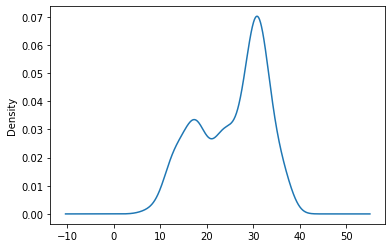

In [58]:
df["meantemp"].plot.kde()

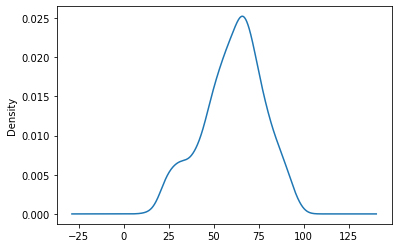

In [59]:
df["humidity"].plot.kde()

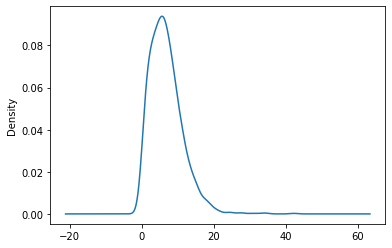

In [60]:
df["wind_speed"].plot.kde()

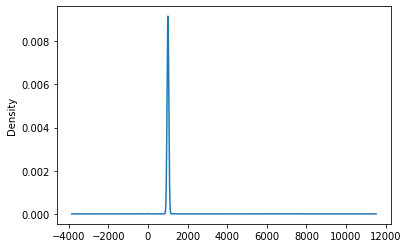

In [61]:
df["meanpressure"].plot.kde()

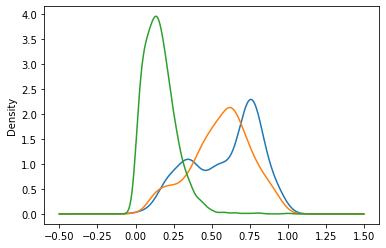

In [62]:
dfScaler["meantemp"].plot.kde()
dfScaler["humidity"].plot.kde()
dfScaler["wind_speed"].plot.kde()

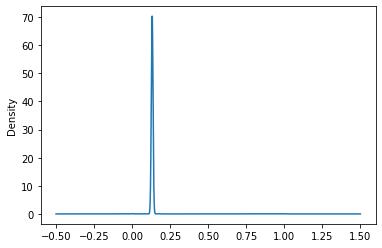

In [63]:
dfScaler["meanpressure"].plot.kde()

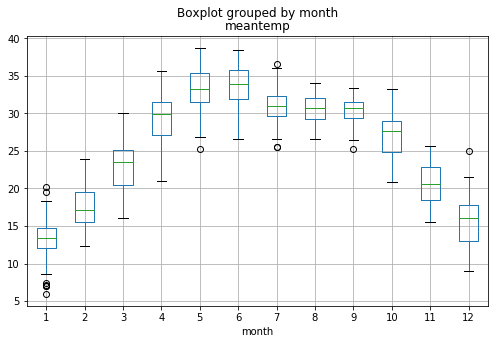

In [64]:
df.boxplot(column=['meantemp'], by= "month" ,figsize=(8,5))

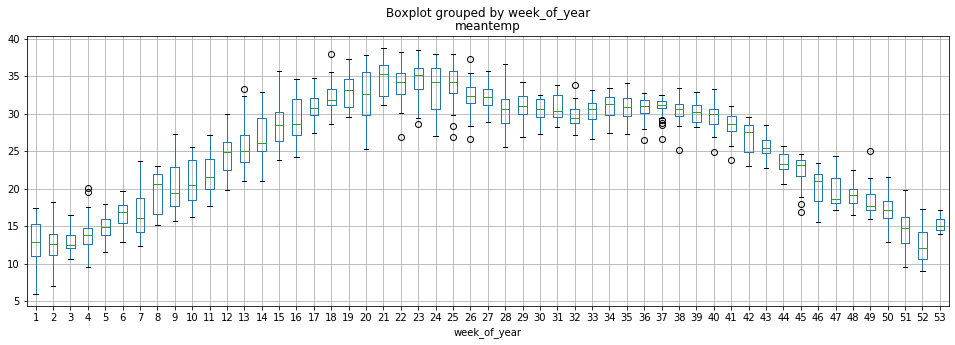

In [65]:
df.boxplot(column=['meantemp'], by= "week_of_year" ,figsize=(16,5))

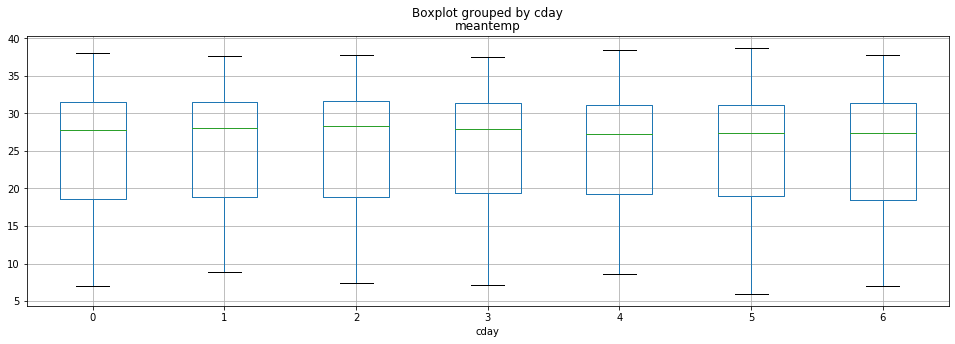

In [66]:
df.boxplot(column=['meantemp'], by= "cday" ,figsize=(16,5))

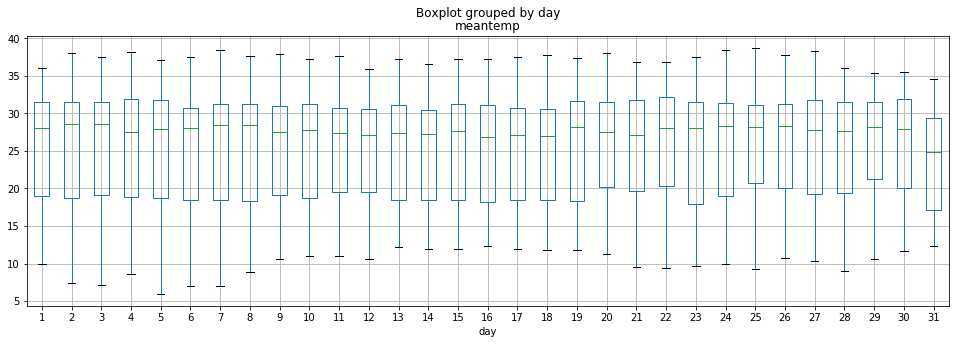

In [67]:
df.boxplot(column=['meantemp'], by= "day" ,figsize=(16,5))

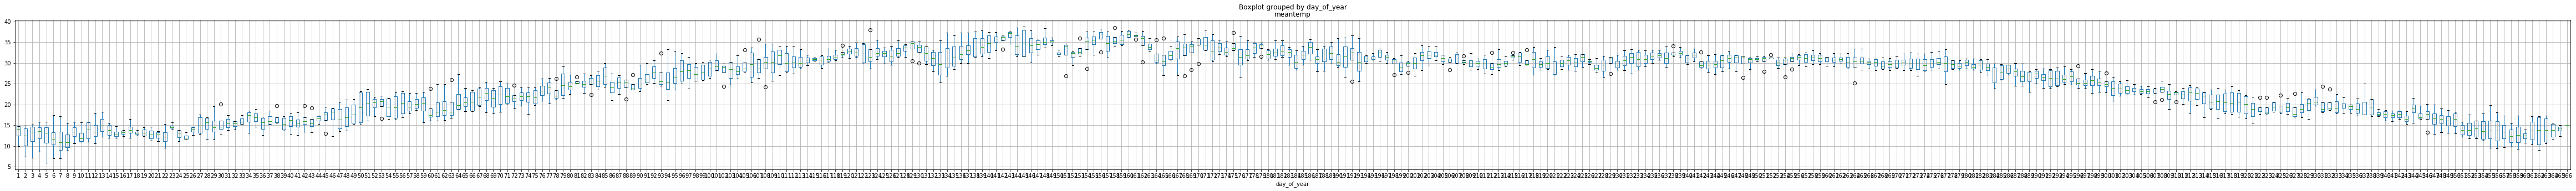

In [68]:
df.boxplot(column=['meantemp'], by= "day_of_year" ,figsize=(80,5))

**Respuesta**

Es válido usar la información solo del día anterior, puesto que entrega suficiente información. Por otro lado, se podría considerar más que el día anterior, pero entonces se estaría repitiendo el uso de un mismo dato siendo que la información que aporta ya habría sido usada (ya estaría en el modelo).

**b)** Entrene un solo Árbol de Regresión de múltiples niveles para resolver el problema. Defina un Árbol **no regularizado** (como el que no tiene límites en su profundidad) y otro Árbol **regularizado** (variando los hiper-parámetros que prefiera, por ejemplo, los más comunes como la profundidad, el número mínimo de datos para realizar *split* o el número mínimo de datos en cada hoja). Además comente sobre la ventaja de usar un árbol de decisión respecto a la escala de los datos ¿Porqué no es necesario escalar los datos?

In [69]:
import numpy as np

from sklearn.tree import DecisionTreeRegressor as Tree

def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )

# Unregularized model -- default parameters
model_unr = Tree()
model_unr.fit(X_train,y_train)

# Regularized tree model
model_reg = Tree(splitter='best', max_depth=5, min_samples_split=5, max_leaf_nodes=14)
model_reg.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=14,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

**Respuesta**

La ventaja es que los datos se procesan según su propia naturaleza, dicho de otra manera, en el árbol serán comparados los datos entre sí, por lo que ya están a su misma escala. Así, no es necesario escalar los datos puesto que en este caso se hará una comparación entre ellos, a  diferencia de otros modelos en que se necesita tenerlos de forma normalizada, por ejemplo para obtener su etiqueta entre 0 y 1.

**c)** Para evaluar la calidad de predicción en este problema se utilizará la métrica Root Mean Squared Error (RMSE), indicando un error en la escala real de la temperatura. Como los datos de validación siguen con el orden temporal, visualice esa predicción a lo largo del tiempo. Comente sobre los resultados comparando la regularización vs el no regularizar.

> **1) Unregularized**



RMSE train=  0.0
RMSE val=  2.6568248513610473


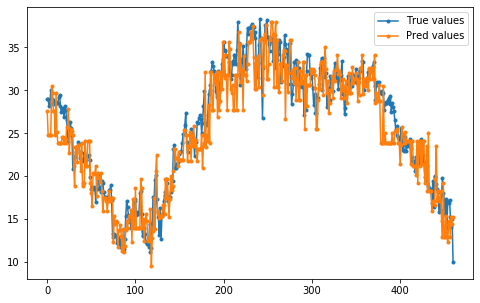

In [70]:
import matplotlib.pyplot as plt

y_train_hat = model_unr.predict(X_train)
y_val_hat = model_unr.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))

plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()

**2) Regularized**

RMSE train=  1.6612681497646347
RMSE val=  1.6878041253762064


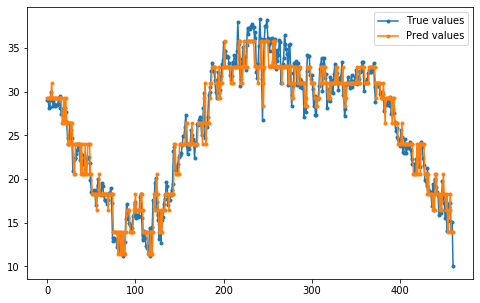

In [71]:
y_train_hat = model_reg.predict(X_train)
y_val_hat = model_reg.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))

plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()

**Respuesta**

En el caso no regularizado se observa que los datos predichos son "poco precisos" en el sentido de que tienen una desviación respecto al valor real en casi todos los datos, lo cual se vuelve evidente en la gráfica. De otra manera se podría decir que en este caso los datos predichos no calzan bien con los datos verdaderos, están en torno a ellos (y su tendencia es similar) pero hay un grado alto de dispersión.

Por su parte, los valores obtenidos por el árbol regularizado se aprecian más ajustados al valor verdadero. En la gráfica se evidencia que no hay dispersión significativa en la tendencia de los valores predichos respecto a los valores reales.

Así, se tiene que es más preciso el árbol regularizado que el no regularizado. Numéricamente también se puede apreciar que el árbol regularizado obtiene mejores resultados, pues el RMSE de prueba obtenido por este es menor que el del no regularizado, además de que el no regularizado tiene overfitting apreciable.

**d)** Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de Bagging, compare el Árbol no regularizado con el regularizado (seteando los hiper-parámetros en base a lo experimentado anteriormente en b)) ¿Qué debería suceder? ¿Se visualiza overfitting? Varíe la cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.

**Respuesta - primera pregunta**

Debería suceder que en el caso del árbol no regularizado haya overfitting. Mientras que en el caso del árbol regularizado se espera que tenga un error de entrenamiento, aunque cercano al error de prueba (suponiendo que sigue el comportamiento observado en c))

**1) Unregularized**

In [0]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import BaggingRegressor

RMSE_train_list = []
RMSE_test_list = []

for n_estimator in range(100):

  # to avoid n_estimator = 0
  n_estimator = n_estimator + 1

  model = BaggingRegressor(base_estimator=model_unr, n_estimators=n_estimator, n_jobs=-1)
  model.fit(X_train,y_train)

  y_train_hat = model.predict(X_train)
  y_val_hat = model.predict(X_val)
  RMSE_train_list.append(RMSE(y_train,y_train_hat))
  RMSE_test_list.append(RMSE(y_val,y_val_hat))

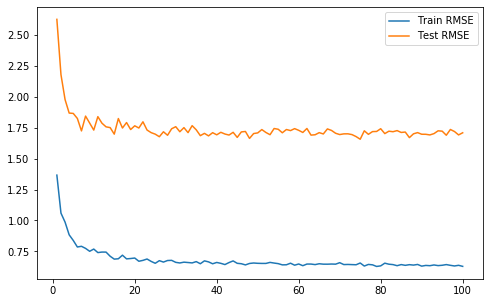

In [73]:
x_axis = np.arange(101)[1:]
plt.figure(figsize=(8,5))
plt.plot(x_axis, RMSE_train_list,label="Train RMSE")
plt.plot(x_axis, RMSE_test_list,label="Test RMSE")
plt.legend()
plt.show()

**2) Regularized**

In [0]:
RMSE_train_list = []
RMSE_test_list = []

for n_estimator in range(100):

  # to avoid n_estimator = 0
  n_estimator = n_estimator + 1

  model = BaggingRegressor(base_estimator=model_reg, n_estimators=n_estimator, n_jobs=-1)
  model.fit(X_train,y_train)

  y_train_hat = model.predict(X_train)
  y_val_hat = model.predict(X_val)
  RMSE_train_list.append(RMSE(y_train,y_train_hat))
  RMSE_test_list.append(RMSE(y_val,y_val_hat))

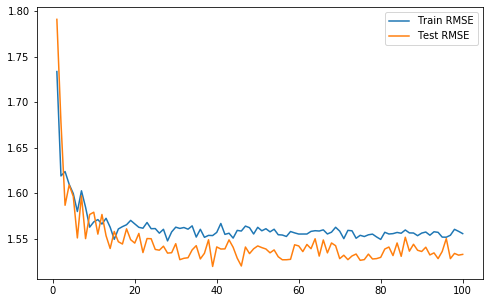

In [75]:
x_axis = np.arange(101)[1:]
plt.figure(figsize=(8,5))
plt.plot(x_axis, RMSE_train_list,label="Train RMSE")
plt.plot(x_axis, RMSE_test_list,label="Test RMSE")
plt.legend()
plt.show()

**Respuesta - segunda pregunta**

Efectivamente se observa overfitting en el caso del árbol no regularizado, obteniendo un error de prueba considerablemente mayor en ese caso.

En cuanto al árbol regularizado, se observa un comportamiento diferente, sin overfitting, en que el RMSE de entrenamiento es mayor que el de prueba.


**e)** Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de AdaBoost, compare el Árbol no regularizado con el regularizado (seteando los hiper-parámetros en base a lo experimentado anteriormente en d) ¿Se visualiza overfitting? ¿Qué técnica utiliza la librería de sklearn, re-muestrear o pesar ejemplos? ¿Qué le parece más sensato?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro. Compare y analice con la técnica utilizada en d).

**1) Unregularized**

In [0]:
from sklearn.ensemble import AdaBoostRegressor

RMSE_train_list = []
RMSE_test_list = []

for n_estimator in range(100):

  # to avoid n_estimator = 0
  n_estimator = n_estimator + 1

  model = AdaBoostRegressor(base_estimator=model_unr, n_estimators=n_estimator)
  model.fit(X_train,y_train)

  y_train_hat = model.predict(X_train)
  y_val_hat = model.predict(X_val)
  RMSE_train_list.append(RMSE(y_train,y_train_hat))
  RMSE_test_list.append(RMSE(y_val,y_val_hat))

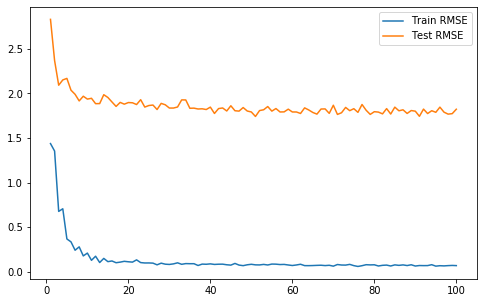

In [77]:
x_axis = np.arange(101)[1:]
plt.figure(figsize=(8,5))
plt.plot(x_axis, RMSE_train_list,label="Train RMSE")
plt.plot(x_axis, RMSE_test_list,label="Test RMSE")
plt.legend()
plt.show()

**2) Regularized**

In [0]:
RMSE_train_list = []
RMSE_test_list = []

for n_estimator in range(100):

  # to avoid n_estimator = 0
  n_estimator = n_estimator + 1

  model = AdaBoostRegressor(base_estimator=model_reg, n_estimators=n_estimator)
  model.fit(X_train,y_train)

  y_train_hat = model.predict(X_train)
  y_val_hat = model.predict(X_val)
  RMSE_train_list.append(RMSE(y_train,y_train_hat))
  RMSE_test_list.append(RMSE(y_val,y_val_hat))

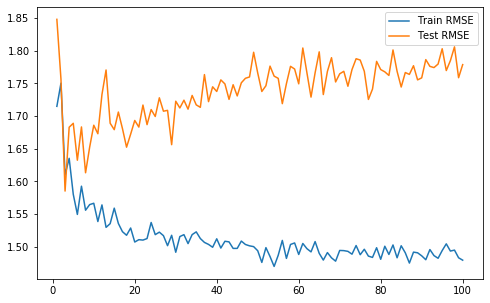

In [79]:
x_axis = np.arange(101)[1:]
plt.figure(figsize=(8,5))
plt.plot(x_axis, RMSE_train_list,label="Train RMSE")
plt.plot(x_axis, RMSE_test_list,label="Test RMSE")
plt.legend()
plt.show()

**Respuesta - primera pregunta**

Esta vez en ambos casos, con árbol regularizado y no regularizado, se observa overfitting. Sin embargo, como se vio anteriormente, es peor el overfitting del caso no regularizado.

**Respuesta - segunda pregunta**

De acuerdo a la documentación de Sklearn sobre AdaBoost [5] se tiene que esta librería utiliza la técnica de pesar ejemplos.

**Respuesta - tercera pregunta**

Creemos que depende del problema. En este caso nos parece más sensato re-muestrar, puesto que dar peso a los ejemplos no aplica al caso a menos que se tenga alguna información que permita justificar el uso de esa técnica. Mientras que con re-muestreo se pueden aprovechar mejor los datos que se tienen para este problema.

**f)** Pruebe otra técnica de ensamblado dedicada a árboles de decisión, que combina el muestreo boostrap de Bagging con muestreo sobre las features: Random Forest, compare el Árbol no regularizado con el regularizado ¿Se visualiza overfitting?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.

**1) Unregularized**

In [0]:
from sklearn.ensemble import RandomForestRegressor

RMSE_train_list = []
RMSE_test_list = []

for n_estimator in range(100):

  # to avoid n_estimator = 0
  n_estimator = n_estimator + 1

  model_unr = RandomForestRegressor(n_estimators=n_estimator, n_jobs=-1)
  model_unr.fit(X_train,y_train)

  y_train_hat = model_unr.predict(X_train)
  y_val_hat = model_unr.predict(X_val)
  RMSE_train_list.append(RMSE(y_train,y_train_hat))
  RMSE_test_list.append(RMSE(y_val,y_val_hat))

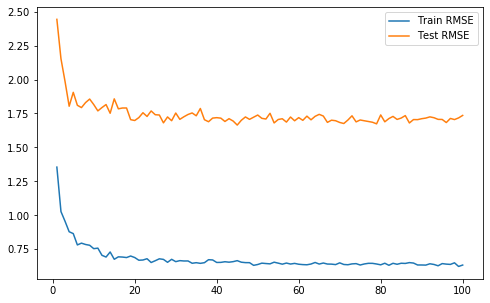

In [81]:
x_axis = np.arange(101)[1:]
plt.figure(figsize=(8,5))
plt.plot(x_axis, RMSE_train_list,label="Train RMSE")
plt.plot(x_axis, RMSE_test_list,label="Test RMSE")
plt.legend()
plt.show()

**2) Regularized**

In [0]:
RMSE_train_list = []
RMSE_test_list = []

for n_estimator in range(100):

  # to avoid n_estimator = 0
  n_estimator = n_estimator + 1

  model_reg = RandomForestRegressor(n_estimators=n_estimator, n_jobs=-1, max_depth=5, min_samples_split=5, max_leaf_nodes=14)
  model_reg.fit(X_train,y_train)

  y_train_hat = model_reg.predict(X_train)
  y_val_hat = model_reg.predict(X_val)
  RMSE_train_list.append(RMSE(y_train,y_train_hat))
  RMSE_test_list.append(RMSE(y_val,y_val_hat))


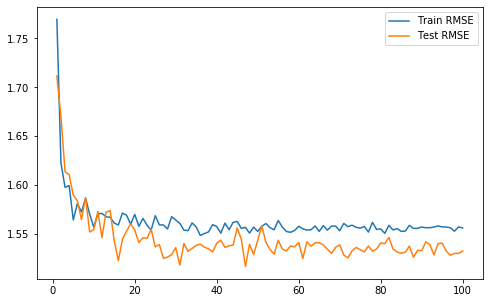

In [83]:
x_axis = np.arange(101)[1:]
plt.figure(figsize=(8,5))
plt.plot(x_axis, RMSE_train_list,label="Train RMSE")
plt.plot(x_axis, RMSE_test_list,label="Test RMSE")
plt.legend()
plt.show()

**Respuesta**

En este caso se observa nuevamente overfitting considerable en el caso del árbol no regularizado. Por su parte, en el caso del árbol regularizado se observa que el RMSE de entrenamiento es mayor que el de prueba.

**g)** Verifique que el OOB error (out of bag error) de los ensambladores que utilizan la técnica boostrap puede ser una alternativa como métrica de generalización, compare con el error calculado sobre el conjunto de validación (o en su defecto cross validation).

**1) Unregularized**

In [0]:
# Unregularized model -- default parameters
model_unr = Tree()
model_unr.fit(X_train,y_train)

oob_error_train_list = []
val_error_list = []
no_estimators = np.arange(20, 50)
for n_estimator in no_estimators:

  n_estimator = n_estimator

  model = BaggingRegressor(base_estimator=model_unr, n_estimators=n_estimator, n_jobs=-1, oob_score=True)
  model.fit(X_train,y_train)

  y_train_hat = model.predict(X_train)
  y_val_hat = model.predict(X_val)
  oob_error_train_list.append(model.oob_score_)
  val_error_list.append(model.score(X_val,y_val))

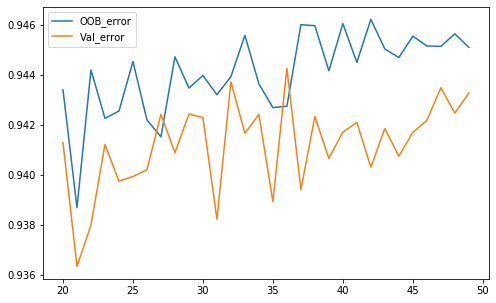

In [85]:
x_axis = np.arange(101)[1:]
plt.figure(figsize=(8,5))
plt.plot(no_estimators, oob_error_train_list,label="OOB_error")
plt.plot(no_estimators, val_error_list,label="Val_error")
plt.legend()
plt.show()

In [0]:
# Regularized tree model
model_reg = Tree(splitter='best', max_depth=5, min_samples_split=5, max_leaf_nodes=14)
model_reg.fit(X_train,y_train)

oob_error_train_list = []
val_error_list = []
no_estimators = np.arange(20, 50)
for n_estimator in no_estimators:

  n_estimator = n_estimator

  model = BaggingRegressor(base_estimator=model_reg, n_estimators=n_estimator, n_jobs=-1, oob_score=True)
  model.fit(X_train,y_train)

  y_train_hat = model.predict(X_train)
  y_val_hat = model.predict(X_val)
  oob_error_train_list.append(model.oob_score_)
  val_error_list.append(model.score(X_val,y_val))

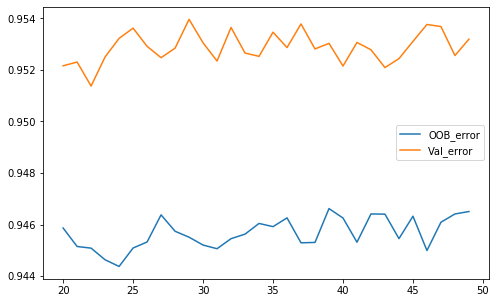

In [87]:
x_axis = np.arange(101)[1:]
plt.figure(figsize=(8,5))
plt.plot(no_estimators, oob_error_train_list,label="OOB_error")
plt.plot(no_estimators, val_error_list,label="Val_error")
plt.legend()
plt.show()

**Respuesta**

De acuerdo a lo observado en las gráficas se tiene que no podría ser usado como métrica de generalización, puesto que se ha visto en todos los otros casos que el árbol no regularizado tiene overfitting y que el regularizado se ajusta mejor a los valores reales, pero con el OOB se observa una situación totalmente opuesta, por lo que no refleja lo obtenido en la mayoría de los casos.

**h)** Defina otra forma de combinar los valores que entregan los ensamblados al hacer predicciones y compare con lo que se hace actualmente, por ejemplo Bagging realiza el voto de la mayoría para clasificación y promedio para regresión, AdaBoost realiza una combinación ponderada de cada clasificador dependiendo de su habilidad (desempeño para clasificar el conjunto de entrenamiento). Se puede inspirar desde clásicos estadísticos, como entregar el primer cuartíl ( 𝑄1 ) si al ensamblado le cuesta predecir valores bajos, o el segundo cuartil ( 𝑄2 ) o mediana para ser robusto a predicciones atípicas de modelos.

In [88]:
def combine_predictions(predictions):

  new_predictions = []

  df_list_predictions = pd.DataFrame(predictions)
  df_details = df_list_predictions.describe()

  for i in range(df_details.shape[1]):

    q1 = df_details[i]["25%"]
    q2 = df_details[i]["50%"]
    q3 = df_details[i]["75%"]

    q1_diff = abs(y_train[i] - q1)/float(y_train[i])
    q3_diff = abs(y_train[i] - q3)/float(y_train[i])

    if q1_diff > 0.5:

      new_predictions.append(q1)

    elif q3_diff > 0.5:

      new_predictions.append(q3)

    else:
      new_predictions.append(q2)

    return new_predictions

list_estimators = model.estimators_
list_predictions = [estimator.predict(X_val) for estimator in list_estimators]
new_predictions = combine_predictions(list_predictions)
print("RMSE val= ",RMSE(y_val, new_predictions))

RMSE val=  7.730792898098649


**i)** Si se cuenta con una gran cantidad de modelos en el ensamblado, por ejemplo  𝑇>100 , se puede crear un intervalo de confianza de la predicción a través de todos estos valores, asumiendo una distribución Normal centrada en la media muestral de las predicciones, con desviación estándar muestral en las predicciones. El intervalo de confianza entrega más información que un único valor puntual de predicción. Visualice un intervalo de confianza al 95% de probabilidad en la predicción a lo largo de la serie de tiempo de validación, comente. Al asumir una distribución Normal, también puede explorar el tomar como predicción del ensamblado el muestreo sobre la distribución Normal creada entorno a los datos muestrales.

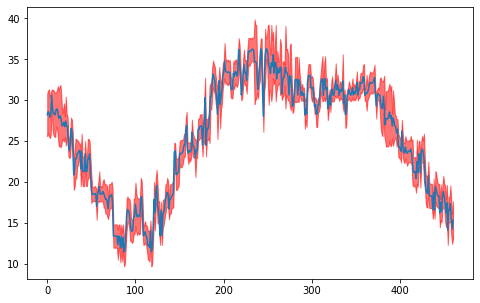

In [89]:
X_val_est = np.vstack(list_predictions).T #has shape=(N_test, n_estimator), with n_estimator>100
from scipy.stats import norm
interv_val = []
for n in range(X_val.shape[0]):
    low, up = norm.interval(0.95, loc=np.mean(X_val_est[n]), scale=np.std(X_val_est[n]))
    interv_val.append([low,up])
interv_val = np.asarray(interv_val)
x = np.arange(X_val_est.shape[0])
plt.figure(figsize=(8,5))
plt.plot(x, np.mean(X_val_est, axis=1))
plt.fill_between(x, interv_val[:,0], interv_val[:,1], color='r', alpha=.55)
plt.show()

Al utilizar este método se tiene mayor certeza de la exactitud de los datos predichos por el modelo, por lo cual es una ayuda para tomar la decisión si es adecuado considerar estos datos o no, dependiendo de la situación para la cual están destinados. Dicho de otra forma, si es crítico un alto grado de exactitud entonces se aprecia inmediatamente de la gráfica que el modelo no entrega resultados útiles, puesto que visualmente se aprecia que en promedio un dato tiene una desviación estándar de 2º.

Así, aunque con el valor puntual ya se puede juzgar la calidad del resultado obtenido, usando un intervalo de confianza agrega información valiosa para saber acerca del rango en el que puede estar un dato.

**j)** Evalúe y visualice la predicción del mejor modelo encontrado para resolver este problema, en el conjunto de pruebas. Además, compare y analice las distintas maneras con las que se resolvió el problema, incluya las decisiones que conlleva y los resultados que reflejan.

In [0]:
df = pd.read_csv(url_test)
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row

#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['day'] = df['date'].dt.day
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.week
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
#any more information?
df.drop(["date"], axis=1, inplace=True) #delete date

y = df.pop("y_value").values
X = df.values 
X_test = X[:1000]
y_test = y[:1000]
X_test, y_test = shuffle(X_test, y_test, random_state=0) #shuffle values on train only

In [0]:
model_reg = Tree(splitter='best', max_depth=5, min_samples_split=5, max_leaf_nodes=14)
model_reg.fit(X_test,y_test)

RMSE_test_list = []

for n_estimator in range(100):

  # to avoid n_estimator = 0
  n_estimator = n_estimator + 1

  model = BaggingRegressor(base_estimator=model_reg, n_estimators=n_estimator, n_jobs=-1)
  model.fit(X_test,y_test)

  y_test_hat = model.predict(X_test)
  RMSE_test_list.append(RMSE(y_test,y_test_hat))

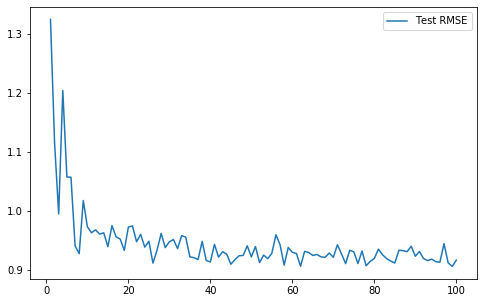

In [93]:
x_axis = np.arange(101)[1:]
plt.figure(figsize=(8,5))
plt.plot(x_axis, RMSE_test_list,label="Test RMSE")
plt.legend()
plt.show()

**Respuesta**

Se usó la técnica Bagging con un árbol regularizdo, pues fue lo que permitió obtener los mejores resultados a lo largo de la experimentación.

Con respecto al tipo de árbol, se halla que es mejor usar un árbol regularizado para este problema, puesto que con un árbol no regularizado se obtienen resultados con overfitting consirable, mientras que con el regularizado se halla una respuesta aceptable.

Con respecto a la técnica, se prefiere Bagging, aunque tanto esta como Random Forest permiten obtener resultados aceptables. Pero, como Random Forest ya considera un tipo de Bagging, se cree mejor optar por esa opción "pura", ya que la diferencia de Random Forest no genera mejora significativa. Por su parte, no se escoge AdaBoost debido a que con esta técnica se obtiene overfitting más severo que con Bagging, y peor RMSE de prueba para el caso regularizado (que también tiene overfitting en esta técnica).

Usar Bagging con árbol regularizado implica mayor gasto de recursos, ya que toma tiempo considerable la ejecución de esta técnica si se tiene una instancia grande. A su vez, también hay que buscar los mejores parámetros para regularizar el árbol, lo que también implica gastar tiempo y memoria en iterar sobre las distintas posibilidades.

<a id="refs"></a>
## Referencias
[1] https://scikit-learn.org/stable/modules/ensemble.html  
[2] https://scikit-learn.org/stable/modules/tree.html  
[3] http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html  
[4] https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

[5] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html